1. Підключення Google Диску та встановлення необхідних бібліотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q torch torchvision matplotlib scikit-learn


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00


2. Імпорт бібліотек і налаштування пристрою (GPU/CPU)

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


3. Аугментація, трансформації та визначення класу Dataset

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

class ArtifactDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_name = self.image_files[idx]
        label = int(image_name.split('_')[-1].split('.')[0])
        image = Image.open(os.path.join(self.image_dir, image_name)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


4. Створення DataLoader'ів та візуалізація аугментованих прикладів

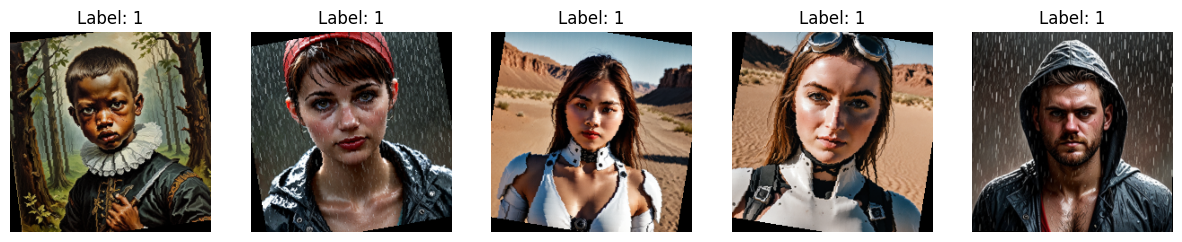

In [ ]:
train_dir = '/content/drive/MyDrive/DeepLearningData/train'
test_dir = '/content/drive/MyDrive/DeepLearningData/test'

full_train_dataset = ArtifactDataset(train_dir, transform=train_transforms)
test_dataset = ArtifactDataset(test_dir, transform=test_transforms)

val_size = int(0.2 * len(full_train_dataset))
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

def show_augmented_images(dataset, n=5):
    fig, axs = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        img, label = dataset[random.randint(0, len(dataset)-1)]
        axs[i].imshow(img.permute(1, 2, 0))
        axs[i].set_title(f"Label: {label}")
        axs[i].axis("off")
    plt.show()

show_augmented_images(full_train_dataset)


5. Опис архітектури моделей: власна CNN та ResNet-18

In [ ]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 28 * 28, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return torch.sigmoid(self.fc2(x))

def get_resnet18():
    model = models.resnet18(pretrained=True)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 1),
        nn.Sigmoid()
    )
    return model


6. Функції тренування та валідації моделей

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.to(device)
    train_loss_list, val_loss_list, f1_list = [], [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_loss, val_f1 = evaluate_model(model, val_loader, criterion)
        train_loss_list.append(total_loss / len(train_loader))
        val_loss_list.append(val_loss)
        f1_list.append(val_f1)
        print(f"Epoch {epoch+1}: Train Loss={total_loss:.4f}, Val Loss={val_loss:.4f}, F1={val_f1:.4f}")

    return train_loss_list, val_loss_list, f1_list

def evaluate_model(model, data_loader, criterion):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='micro')
    return total_loss / len(data_loader), f1


7. Навчання моделей (Custom CNN і ResNet-18)

In [ ]:
criterion = nn.BCELoss()

custom_model = CustomCNN()
optimizer_custom = torch.optim.Adam(custom_model.parameters(), lr=1e-4)
custom_train_loss, custom_val_loss, custom_f1 = train_model(
    custom_model, train_loader, val_loader, criterion, optimizer_custom, epochs=10
)

resnet_model = get_resnet18()
optimizer_resnet = torch.optim.Adam(resnet_model.parameters(), lr=1e-4)
resnet_train_loss, resnet_val_loss, resnet_f1 = train_model(
    resnet_model, train_loader, val_loader, criterion, optimizer_resnet, epochs=10
)

torch.save(resnet_model.state_dict(), 'best_resnet_model.pth')


100%|██████████| 45/45 [05:20<00:00,  7.13s/it]


Epoch 1: Train Loss=16.2661, Val Loss=0.2679, F1=0.9250


100%|██████████| 45/45 [01:21<00:00,  1.80s/it]


Epoch 2: Train Loss=13.9004, Val Loss=0.2510, F1=0.9250


100%|██████████| 45/45 [01:18<00:00,  1.75s/it]


Epoch 3: Train Loss=13.5243, Val Loss=0.2479, F1=0.9250


100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


Epoch 4: Train Loss=13.1421, Val Loss=0.2493, F1=0.9250


100%|██████████| 45/45 [01:18<00:00,  1.74s/it]


Epoch 5: Train Loss=12.8071, Val Loss=0.2784, F1=0.9278


100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


Epoch 6: Train Loss=12.8783, Val Loss=0.2432, F1=0.9250


100%|██████████| 45/45 [01:18<00:00,  1.74s/it]


Epoch 7: Train Loss=12.4429, Val Loss=0.2461, F1=0.9278


100%|██████████| 45/45 [01:19<00:00,  1.76s/it]


Epoch 8: Train Loss=12.5411, Val Loss=0.2337, F1=0.9250


100%|██████████| 45/45 [01:18<00:00,  1.74s/it]


Epoch 9: Train Loss=11.8904, Val Loss=0.2342, F1=0.9222


100%|██████████| 45/45 [01:18<00:00,  1.74s/it]


Epoch 10: Train Loss=11.7041, Val Loss=0.2363, F1=0.9250


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]
100%|██████████| 45/45 [01:20<00:00,  1.78s/it]


Epoch 1: Train Loss=17.7858, Val Loss=0.1604, F1=0.9639


100%|██████████| 45/45 [01:22<00:00,  1.82s/it]


Epoch 2: Train Loss=6.4637, Val Loss=0.1800, F1=0.9500


100%|██████████| 45/45 [01:20<00:00,  1.78s/it]


Epoch 3: Train Loss=4.9385, Val Loss=0.1301, F1=0.9611


100%|██████████| 45/45 [01:20<00:00,  1.79s/it]


Epoch 4: Train Loss=3.0591, Val Loss=0.1459, F1=0.9583


100%|██████████| 45/45 [01:20<00:00,  1.79s/it]


Epoch 5: Train Loss=1.9477, Val Loss=0.1172, F1=0.9667


100%|██████████| 45/45 [01:21<00:00,  1.82s/it]


Epoch 6: Train Loss=2.0060, Val Loss=0.1305, F1=0.9667


100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


Epoch 7: Train Loss=1.9701, Val Loss=0.1151, F1=0.9583


100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


Epoch 8: Train Loss=1.4520, Val Loss=0.0887, F1=0.9778


100%|██████████| 45/45 [01:19<00:00,  1.77s/it]


Epoch 9: Train Loss=1.0856, Val Loss=0.1235, F1=0.9639


100%|██████████| 45/45 [01:19<00:00,  1.76s/it]


Epoch 10: Train Loss=1.4432, Val Loss=0.1343, F1=0.9611


8. Побудова графіків втрат (Loss) та F1-міри

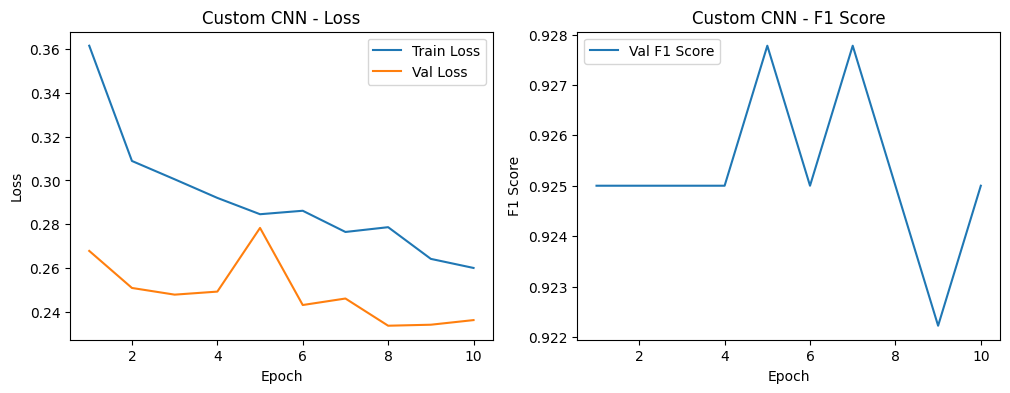

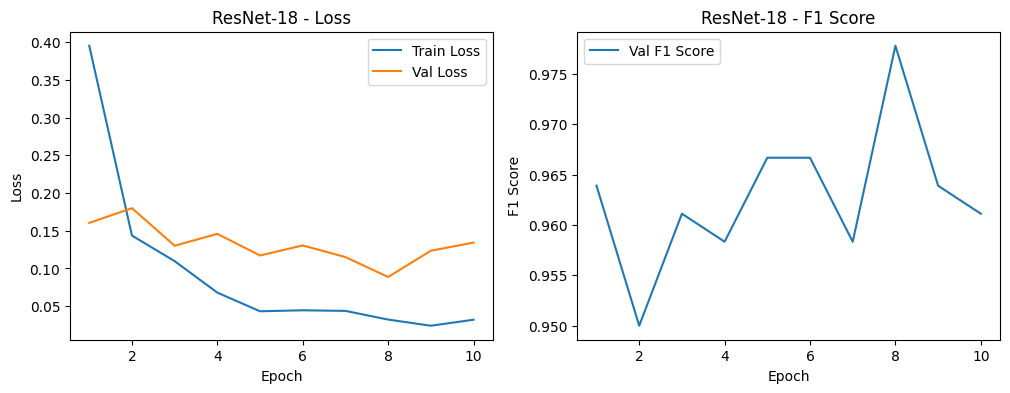

In [ ]:
def plot_metrics(train_loss, val_loss, f1_list, model_name):
    epochs = range(1, len(train_loss)+1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.title(f"{model_name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, f1_list, label='Val F1 Score')
    plt.title(f"{model_name} - F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.show()

plot_metrics(custom_train_loss, custom_val_loss, custom_f1, "Custom CNN")
plot_metrics(resnet_train_loss, resnet_val_loss, resnet_f1, "ResNet-18")


9. Виведення матриці плутанини для тестового набору

Custom CNN:


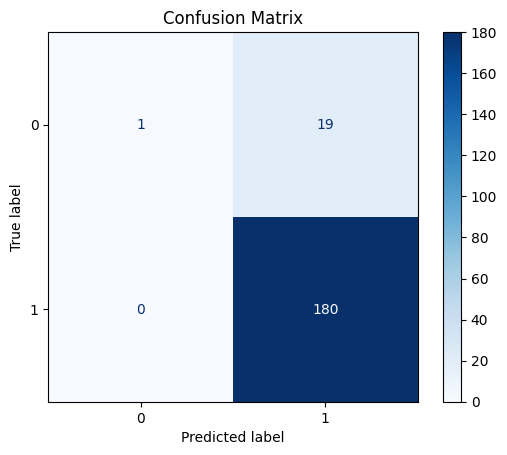

ResNet-18:


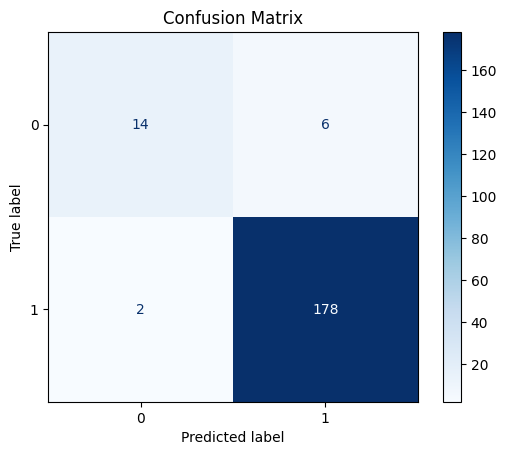

In [ ]:
def show_confusion_matrix(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).int().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

print("Custom CNN:")
show_confusion_matrix(custom_model, test_loader)

print("ResNet-18:")
show_confusion_matrix(resnet_model, test_loader)
